# Project 3

### We are looking at a dataset of alcohol sales for the state of Iowa and looking at useful inferences from the dataset, as well as setting up a model in an effort to forecast sales (and other numbers such as bottles sold, etc) and prescribe to either the Iowa tax authority or a aspiring liquor store owner  recommendations on sales forecasts, and geographic targets for a new store.

The problem statement we are addressing in this Project is where to ideally open a new store somewhere in Iowa.  We are performing the analysis on  data from the Iowa alcohol website on a county level.  We can of course drill down further from the county level into the city and zip code level, but as a good first step we examine results by county.  We are performing analyses on sales, profits, and other factors which we believe affect future sales.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels as sm
%matplotlib inline
from scipy.stats import mode
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import cross_val_predict
from sklearn.metrics import r2_score

## Load the data into a DataFrame
df = pd.read_csv('/Users/michael/DSI-projects/project-03/assets/Iowa_Liquor_Sales_reduced.csv')

## Transform the dates if needed, e.g.
df['Date'] = pd.to_datetime(df['Date'], format = '%m/%d/%Y')

/Users/michael/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
# Check for missing values
df.isnull().values.any()

# print out rows contain missing data
null_data = df[df.isnull().any(axis=1)]
# len(null_data)
# len(df)

# take a closer look at the missing data
# null_data.info()

# We believe it's okay to drop rows with na values as they are an insignificant percentage /
# of the total data set

# Create a couple of functions here which will help us clean up the data
def dolflo(x):
    y = x.split('$')
    return float(y[1])
def integerize(x):
    y = int(x)
    return y

# Cleaning up the dataset by converting strings into floats
df['Sale (Dollars)'] = df['Sale (Dollars)'].apply(lambda x: dolflo(x))
df['State Bottle Retail'] = df['State Bottle Retail'].apply(lambda x: dolflo(x))
df['State Bottle Cost'] = df['State Bottle Cost'].apply(lambda x: dolflo(x))

# Setting up a couple new columns to take a look at data in a more concise way
df['BottleMarkup'] = df['State Bottle Retail'] - df['State Bottle Cost'] 
df['Profit'] = df['BottleMarkup'] * df['Bottles Sold']

# Standardizing the spelling of the cities
df['City'] = df['City'].apply(lambda x: x.upper())

# Dropping all rows with NA values (justification is given above)
df.dropna(inplace=True)

# Getting rid of a couple of data points which are extreme outliers in volume
df = df[df['Bottle Volume (ml)']<170000]
df = df[df['Bottle Volume (ml)']>1]

In [3]:
# Creating a new df with which to begin analyses on, also in the    /
# creation of this new df, we're cleaning up a bunch of the columns that /
# aren't needed, and renaming names... 
df1 = df
df = df.drop('Item Number',1)
df = df.drop('Item Description',1)
df = df.drop('Bottle Volume (ml)',1)
df = df.drop('Category Name',1)
df = df.drop('Category',1)
df = df.drop('State Bottle Cost',1)
df = df.drop('State Bottle Retail',1)
df = df.drop('Volume Sold (Gallons)',1)
df = df.rename(columns = {'Bottles Sold':'BottlesSold'})
df = df.rename(columns = {'Sale (Dollars)':'TotalSales'})
df = df.rename(columns = {'Volume Sold (Liters)':'VolumeSold'})

In [4]:
# Creating some "sub" dataframes with which to perform analyses.  
df2015 = pd.DataFrame(df[df['Date']<'2016-01-01'])
df2016 = pd.DataFrame(df[df['Date']>='2016-01-01'])
dfq12015 = pd.DataFrame(df[df['Date']<='2015-03-31'])
# dfq22015 = pd.DataFrame(df[(df['Date']>'2015-03-31') & (df['Date']<='2015-06-30')])
# dfq32015 = pd.DataFrame(df[(df['Date']>'2015-06-30') & (df['Date']<='2015-09-30')])
# dfq42015 = pd.DataFrame(df[(df['Date']>'2015-09-30') & (df['Date']<='2015-12-31')])
dfnotq12015 = pd.DataFrame(df[(df['Date']>'2015-03-31') & (df['Date']<='2015-12-31')])

In [5]:
# Creating "sub" pivot tables on which to perform analyses on
testq12015df = pd.pivot_table(dfq12015,index=['County'],values=['TotalSales','BottlesSold','VolumeSold','Profit'],aggfunc=lambda x: sum(x))
testq12015df = testq12015df.sort_values(by='TotalSales')
testq12015df = testq12015df.reset_index(drop=False)
storesq12015df = pd.pivot_table(dfq12015,index=['County'],values=['Store Number'],aggfunc=lambda x: len(x.unique()))
storesq12015df = storesq12015df.rename(columns = {'Store Number':'NumberofStores'})
storesq12015df = storesq12015df.reset_index(drop=False)
testq12015df = pd.merge(testq12015df, storesq12015df, on='County', how='inner')
testq12015df['SalesPerStore']=testq12015df['TotalSales']/testq12015df['NumberofStores']

testnotq12015df = pd.pivot_table(dfnotq12015,index=['County'],values=['TotalSales','BottlesSold','VolumeSold','Profit'],aggfunc=lambda x: sum(x))
testnotq12015df = testnotq12015df.sort_values(by='TotalSales')
testnotq12015df = testnotq12015df.reset_index(drop=False)
storesnotq12015df = pd.pivot_table(dfq12015,index=['County'],values=['Store Number'],aggfunc=lambda x: len(x.unique()))
storesnotq12015df = storesnotq12015df.rename(columns = {'Store Number':'NumberofStores'})
storesnotq12015df = storesnotq12015df.reset_index(drop=False)
testnotq12015df = pd.merge(testnotq12015df, storesnotq12015df, on='County', how='inner')
testnotq12015df['SalesPerStore']=testnotq12015df['TotalSales']/testnotq12015df['NumberofStores']

test2015df = pd.pivot_table(df2015,index=['County'],values=['TotalSales','BottlesSold','VolumeSold','Profit'],aggfunc=lambda x: sum(x))
test2015df = test2015df.sort_values(by='TotalSales')
test2015df = test2015df.reset_index(drop=False)
stores2015df = pd.pivot_table(df2015,index=['County'],values=['Store Number'],aggfunc=lambda x: len(x.unique()))
stores2015df = stores2015df.rename(columns = {'Store Number':'NumberofStores'})
stores2015df = stores2015df.reset_index(drop=False)
test2015df = pd.merge(test2015df, storesq12015df, on='County', how='inner')
test2015df['SalesPerStore']=test2015df['TotalSales']/test2015df['NumberofStores']

test2016df = pd.pivot_table(df2016,index=['County'],values=['TotalSales','BottlesSold','VolumeSold','Profit'],aggfunc=lambda x: sum(x))
test2016df = test2016df.sort_values(by='TotalSales')
test2016df = test2016df.reset_index(drop=False)
stores2016df = pd.pivot_table(df2016,index=['County'],values=['Store Number'],aggfunc=lambda x: len(x.unique()))
stores2016df = stores2016df.rename(columns = {'Store Number':'NumberofStores'})
stores2016df = stores2016df.reset_index(drop=False)
test2016df = pd.merge(test2016df, storesq12015df, on='County', how='inner')
test2016df['SalesPerStore']=test2016df['TotalSales']/test2016df['NumberofStores']

In [31]:
int(sum(testnotq12015df['TotalSales']))

220959675

From here, we create some data visualizations to get a quick handle on what the data is telling us, and what might look interesting to investigate.  At a first glance, we see that one county in particular seems to dominate all of Iowa.

In [6]:
test2015df.tail(5)

,County,BottlesSold,Profit,TotalSales,VolumeSold,NumberofStores,SalesPerStore
94,Black Hawk,1403322,5.362163e+06,1.604075e+07,1080190.23,68,235893.431029
95,Johnson,1246289,5.899555e+06,1.765712e+07,1111082.08,50,353142.414200
96,Scott,1664132,6.814111e+06,2.040330e+07,1321191.09,63,323861.851111
97,Linn,1959933,8.342350e+06,2.496033e+07,1744361.80,94,265535.422766
98,Polk,4696469,2.125246e+07,6.360941e+07,4064143.31,188,338347.937766


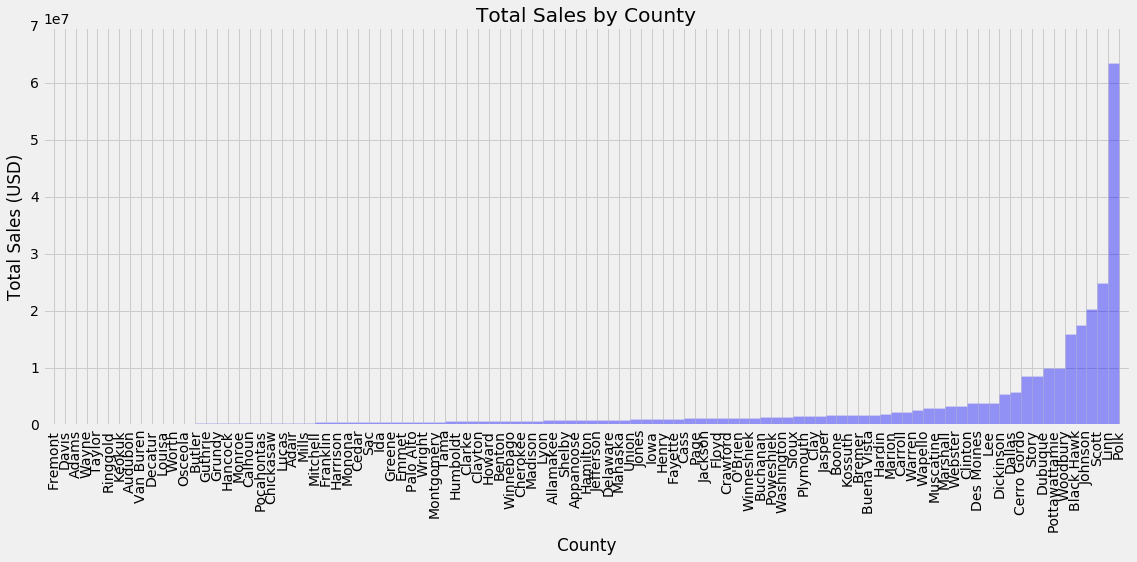

In [7]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(16,8))
axes = fig.gca()
plt.bar(np.arange(len(test2015df)), test2015df['TotalSales'], 1, alpha=0.4)
plt.xlabel('County')
plt.ylabel('Total Sales (USD)')
plt.title('Total Sales by County')
plt.xticks((np.arange(len(test2015df))+1), test2015df['County'], rotation=90)
plt.tight_layout()
plt.show()

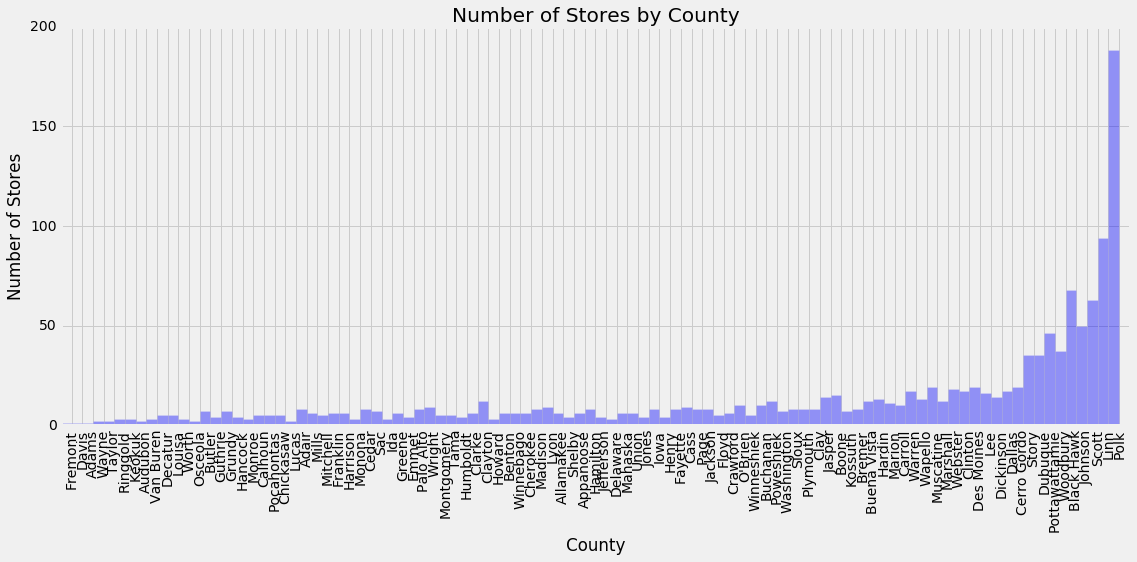

In [8]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(16,8))
axes = fig.gca()
plt.bar(np.arange(len(test2015df)), test2015df['NumberofStores'], 1, alpha=0.4)
plt.xlabel('County')
plt.ylabel('Number of Stores')
plt.title('Number of Stores by County')
plt.xticks((np.arange(len(test2015df))+1), test2015df['County'], rotation=90)
plt.tight_layout()
plt.show()

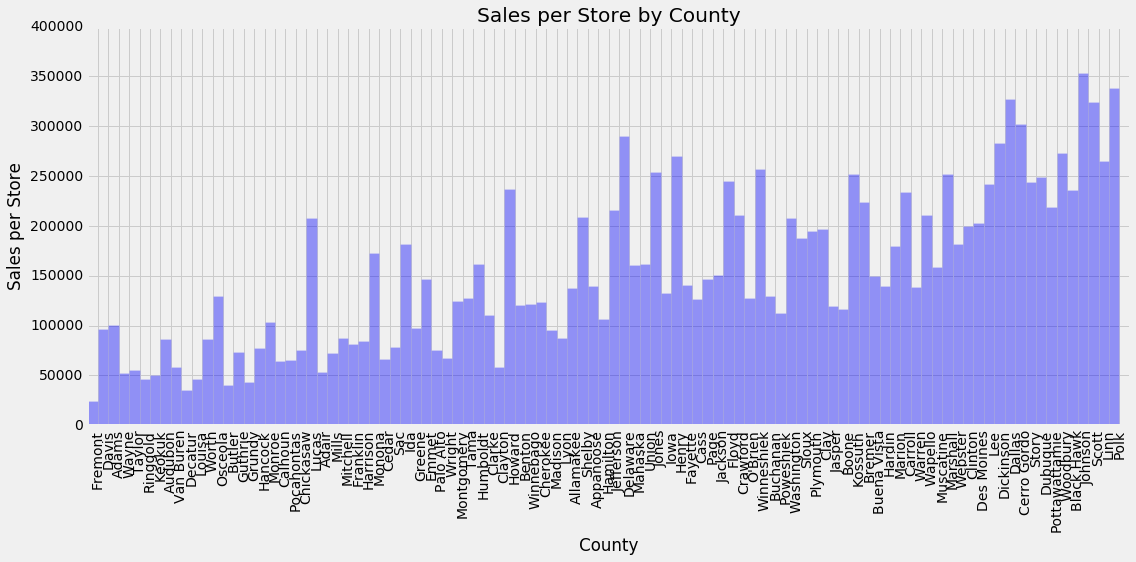

In [9]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(16,8))
axes = fig.gca()
plt.bar(np.arange(len(test2015df)), test2015df['SalesPerStore'], 1, alpha=0.4)
plt.xlabel('County')
plt.ylabel('Sales per Store')
plt.title('Sales per Store by County')
plt.xticks((np.arange(len(test2015df))+1), test2015df['County'], rotation=90)
plt.tight_layout()
plt.show()

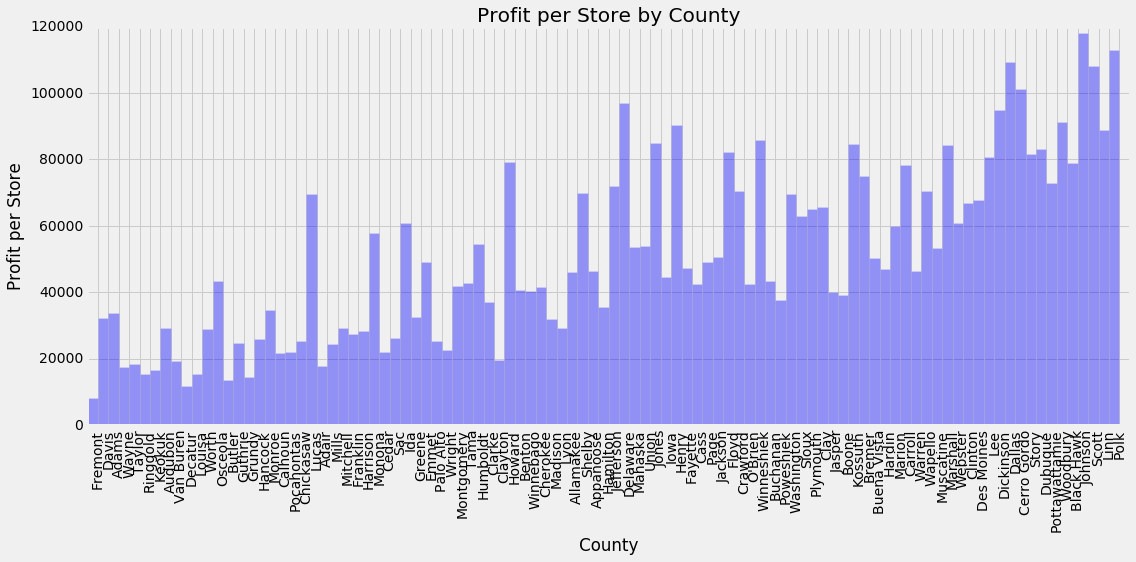

In [10]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(16,8))
axes = fig.gca()
tempx = test2015df['Profit']/test2015df['NumberofStores']
plt.bar(np.arange(len(test2015df)), tempx, 1, alpha=0.4)
plt.xlabel('County')
plt.ylabel('Profit per Store')
plt.title('Profit per Store by County')
plt.xticks((np.arange(len(test2015df))+1), test2015df['County'], rotation=90)
plt.tight_layout()
plt.show()

From the data visualizations, we can see that Polk county seems to have a large share of the sales in the state of Iowa.  We drill down sideways from total sales to look at profitability, and we see that due to the large number of stores in Polk county, the per store numbers aren't as attractive as some of the other high performing counties, such as Linn, county, Johnson county and Scott county.  In fact, it looks like it's an equally attractive opportunity in terms of sales and profit per store, but without the large number of compete stores in the county.  From the data we can also figure out the average markup made on a bottle in the respective counties, and recommend that the store owner target an average profit margin range of 4.10 - 4.73 depending on which county.

# Modeling Q2-Q4 2016 Total Sales

In [11]:
# Preparing a summary df to be used to collect data for analysis at the end, also we do a 
# naive forecast for sales in q2-q4.  This is simply taking q1 sales and assuming the run rate
# continues through the rest of the year
summarydf = test2016df[['County','TotalSales', 'BottlesSold', 'Profit', 'NumberofStores']]
summarydf['NaiveForecast'] = summarydf['TotalSales'] * 3
summarydf['SalesQ2-42015'] = testnotq12015df['TotalSales']

/Users/michael/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


/Users/michael/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


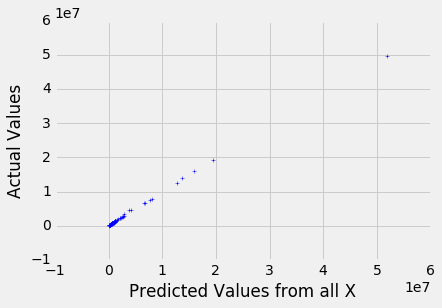

MSE: 61455724219.7
r^2: 0.998971885348
Coefficients: [ -2.87733734e+00   1.78897493e+01  -3.23696729e+01  -7.72773247e+03] [ 104510.59143902]


In [12]:
# We try Lasso first to see if we can optimize the number of coefficients we're using
# in the model.  Performance is good, but it seems that maybe number of bottles sold
# is the least important feature used in the model.  This makes intuitive sense, as 
# we are also using Volume sold (Liters) which is basically the same information, but 
# in a different form.  
lm = linear_model.Lasso(alpha=0.1)

X = testq12015df[['BottlesSold', 'Profit', 'VolumeSold','NumberofStores']]
y = testnotq12015df[['TotalSales']]
TestX = test2016df[['BottlesSold', 'Profit', 'VolumeSold','NumberofStores']]
model = lm.fit(X,y)
predictions = lm.predict(TestX)

# Plot the model
plt.scatter(predictions, y, marker='+', zorder=10)
plt.xlabel("Predicted Values from all X")
plt.ylabel("Actual Values")
plt.show()
print "MSE:", mean_squared_error(y, predictions)
print "r^2:", model.score(X,y)
print "Coefficients:", model.coef_, model.intercept_

In [15]:
np.mean(predictions)

2244021.4876669827

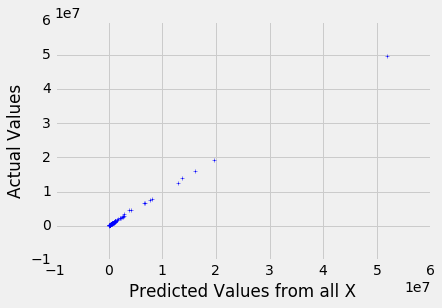

MSE: 65554847847.9
r^2: 0.998886955799
Coefficients: [    16.6368361     -28.62552894 -10768.79102832] [ 104591.75773849]


In [16]:
# We re-run the the Lasso model but without the bottles sold feature.  Performance
# is not improved, but it's not much worse either.  I decide to keep it to just 
# the three features in this model, as the bottles sold feature seems superfluous
# as discussed above.  

lm = linear_model.Lasso(alpha=0.1)

X = testq12015df[['Profit', 'VolumeSold','NumberofStores']]
y = testnotq12015df[['TotalSales']]
TestX = test2016df[['Profit', 'VolumeSold','NumberofStores']]
model = lm.fit(X,y)
predictions = lm.predict(TestX)

# Plot the model
plt.scatter(predictions, y, marker='+', zorder=10)
plt.xlabel("Predicted Values from all X")
plt.ylabel("Actual Values")
plt.show()
print "MSE:", mean_squared_error(y, predictions)
print "r^2:", model.score(X,y)
print "Coefficients:", model.coef_, model.intercept_

In [18]:
np.mean(predictions)

2248127.3494139472

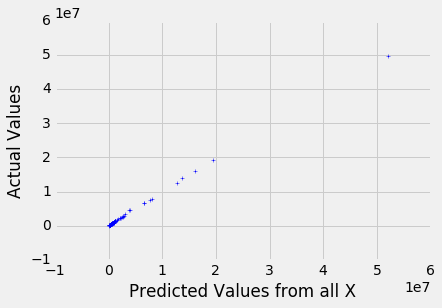

MSE: 68407980554.8
r^2: 0.99892420842
Coefficients: [[   18.29985046   -38.08974266 -6236.1417768 ]] [ 112261.90027831]


In [19]:
# Performing Ridge CV model on the three features, performance is similar to 
# the Lasso model.  
lm = linear_model.RidgeCV()

X = testq12015df[['Profit', 'VolumeSold','NumberofStores']]
y = testnotq12015df[['TotalSales']]
TestX = test2016df[['Profit', 'VolumeSold','NumberofStores']]
model = lm.fit(X,y)
predictions = model.predict(TestX)

# Plot the model
plt.scatter(predictions, y, marker='+', zorder=10)
plt.xlabel("Predicted Values from all X")
plt.ylabel("Actual Values")
plt.show()
print "MSE:", mean_squared_error(y, predictions)
print "r^2:", model.score(X,y)
print "Coefficients:", model.coef_, model.intercept_

In [22]:
int(np.mean(predictions))

2245551

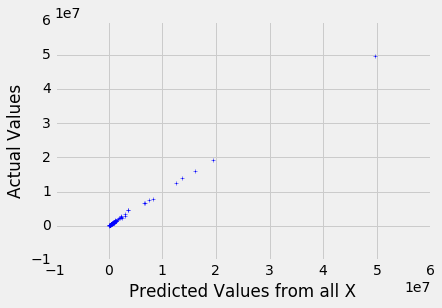

MSE: 35920898578.3
r^2: 0.998924286983
Coefficients: [[   18.29364827   -38.05321961 -6329.32923226]] [ 113166.71015385]


In [32]:
# Linear regression model - this seems to give the best r^2 value so we will use 
# this model for predicting the values for total sales in 2016.
lm = linear_model.LinearRegression()

X = testq12015df[['Profit', 'VolumeSold','NumberofStores']]
y = testnotq12015df[['TotalSales']]
TestX = test2016df[['Profit', 'VolumeSold','NumberofStores']]
model = lm.fit(X,y)
predictions = lm.predict(X)

# Plot the model
plt.scatter(predictions, y,  marker='+', zorder=10)
plt.xlabel("Predicted Values from all X")
plt.ylabel("Actual Values")
plt.show()
print "MSE:", mean_squared_error(y, predictions)
print "r^2:", model.score(X,y)
print "Coefficients:", model.coef_, model.intercept_

In [35]:
int(sum(predictions))

220959675

So using the Linear Regression model to generate predictions for 2016 q2-q4 total sales, we then add those to our summarydf for more analysis.  We create some more data visualizations and make some comparisons between 2015 and our expected 2016 numbers.  We note that total sales across the state appear to be flat, but not necessarily by county.  We also put change in sales (between 2015 actual and 2016 forecasted) as a guide to where a new store might make sense.  

In [36]:
summarydf['2016Q2-4Forecast'] = pd.DataFrame(predictions)
summarydf['Q2-4ChangeInSales']= (summarydf['2016Q2-4Forecast']-summarydf['SalesQ2-42015'])
summarydf['2016Q2-4Forecast']= summarydf['2016Q2-4Forecast'].apply(lambda x: integerize(x))
summarydf['Q2-4ChangeInSales']= summarydf['Q2-4ChangeInSales'].apply(lambda x: integerize(x))
summarydf['2015TotalSales']= test2015df['TotalSales']
summarydf['2016TotalSales']= summarydf['TotalSales']+summarydf['2016Q2-4Forecast']
summarydf['YoYTotalSalesChange'] = summarydf['2016TotalSales']-summarydf['2015TotalSales']


In [37]:
summarydf.tail()

,County,TotalSales,BottlesSold,Profit,NumberofStores,NaiveForecast,SalesQ2-42015,2016Q2-4Forecast,Q2-4ChangeInSales,2015TotalSales,2016TotalSales,YoYTotalSalesChange
94,Black Hawk,3.760191e+06,326287,1.256314e+06,68,1.128057e+07,1.244325e+07,12477052,33800,1.604075e+07,1.623724e+07,196489.729998
95,Johnson,3.821047e+06,277110,1.275288e+06,50,1.146314e+07,1.391837e+07,13607883,-310482,1.765712e+07,1.742893e+07,-228190.270001
96,Scott,4.531437e+06,375932,1.512052e+06,63,1.359431e+07,1.586873e+07,16176815,308087,2.040330e+07,2.070825e+07,304955.559998
97,Linn,5.799921e+06,457275,1.936843e+06,94,1.739976e+07,1.912370e+07,19511306,387607,2.496033e+07,2.531123e+07,350897.439997
98,Polk,1.450703e+07,1105511,4.842004e+06,188,4.352110e+07,4.976962e+07,49694075,-75547,6.360941e+07,6.420111e+07,591695.749967


In [40]:
sum(summarydf['2016TotalSales'])

284575423.83000153

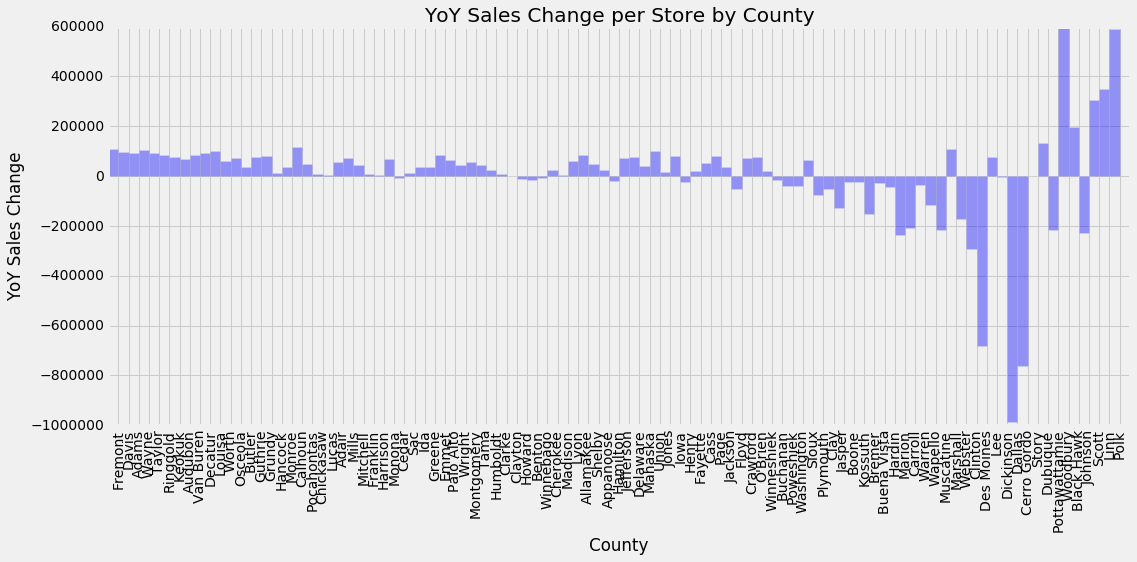

In [18]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(16,8))
axes = fig.gca()
plt.bar(np.arange(len(test2015df)), summarydf['YoYTotalSalesChange'], 1, alpha=0.4)
plt.xlabel('County')
plt.ylabel('YoY Sales Change')
plt.title('YoY Sales Change per Store by County')
plt.xticks((np.arange(len(test2015df))+1), test2015df['County'], rotation=90)
plt.tight_layout()
plt.show()

So looking at the forecasted change in Total Sales by County, we see that both Polk and Johnson county are forecast to have lower total sales this year from last year.  We also see that Scott county remains flattish, whereas Linn county has a bump higher in sales forecasted for 2016.  We would suggest that either Scott or Lin county looks attractive to open a new store, with the average bottle profit margin as suggested above.  

In [19]:
# Converting the file to a CSV so i can play with it in Tableau
from IPython.display import Image
pd.DataFrame(summarydf[['County','YoYTotalSalesChange']]).to_csv('YoYSalesChange.csv')
pd.DataFrame(summarydf[['County','2015TotalSales']]).to_csv('2015TotalSales.csv')
pd.DataFrame(summarydf[['County','2016TotalSales']]).to_csv('2016TotalSales.csv')

And some Tableau stuff....

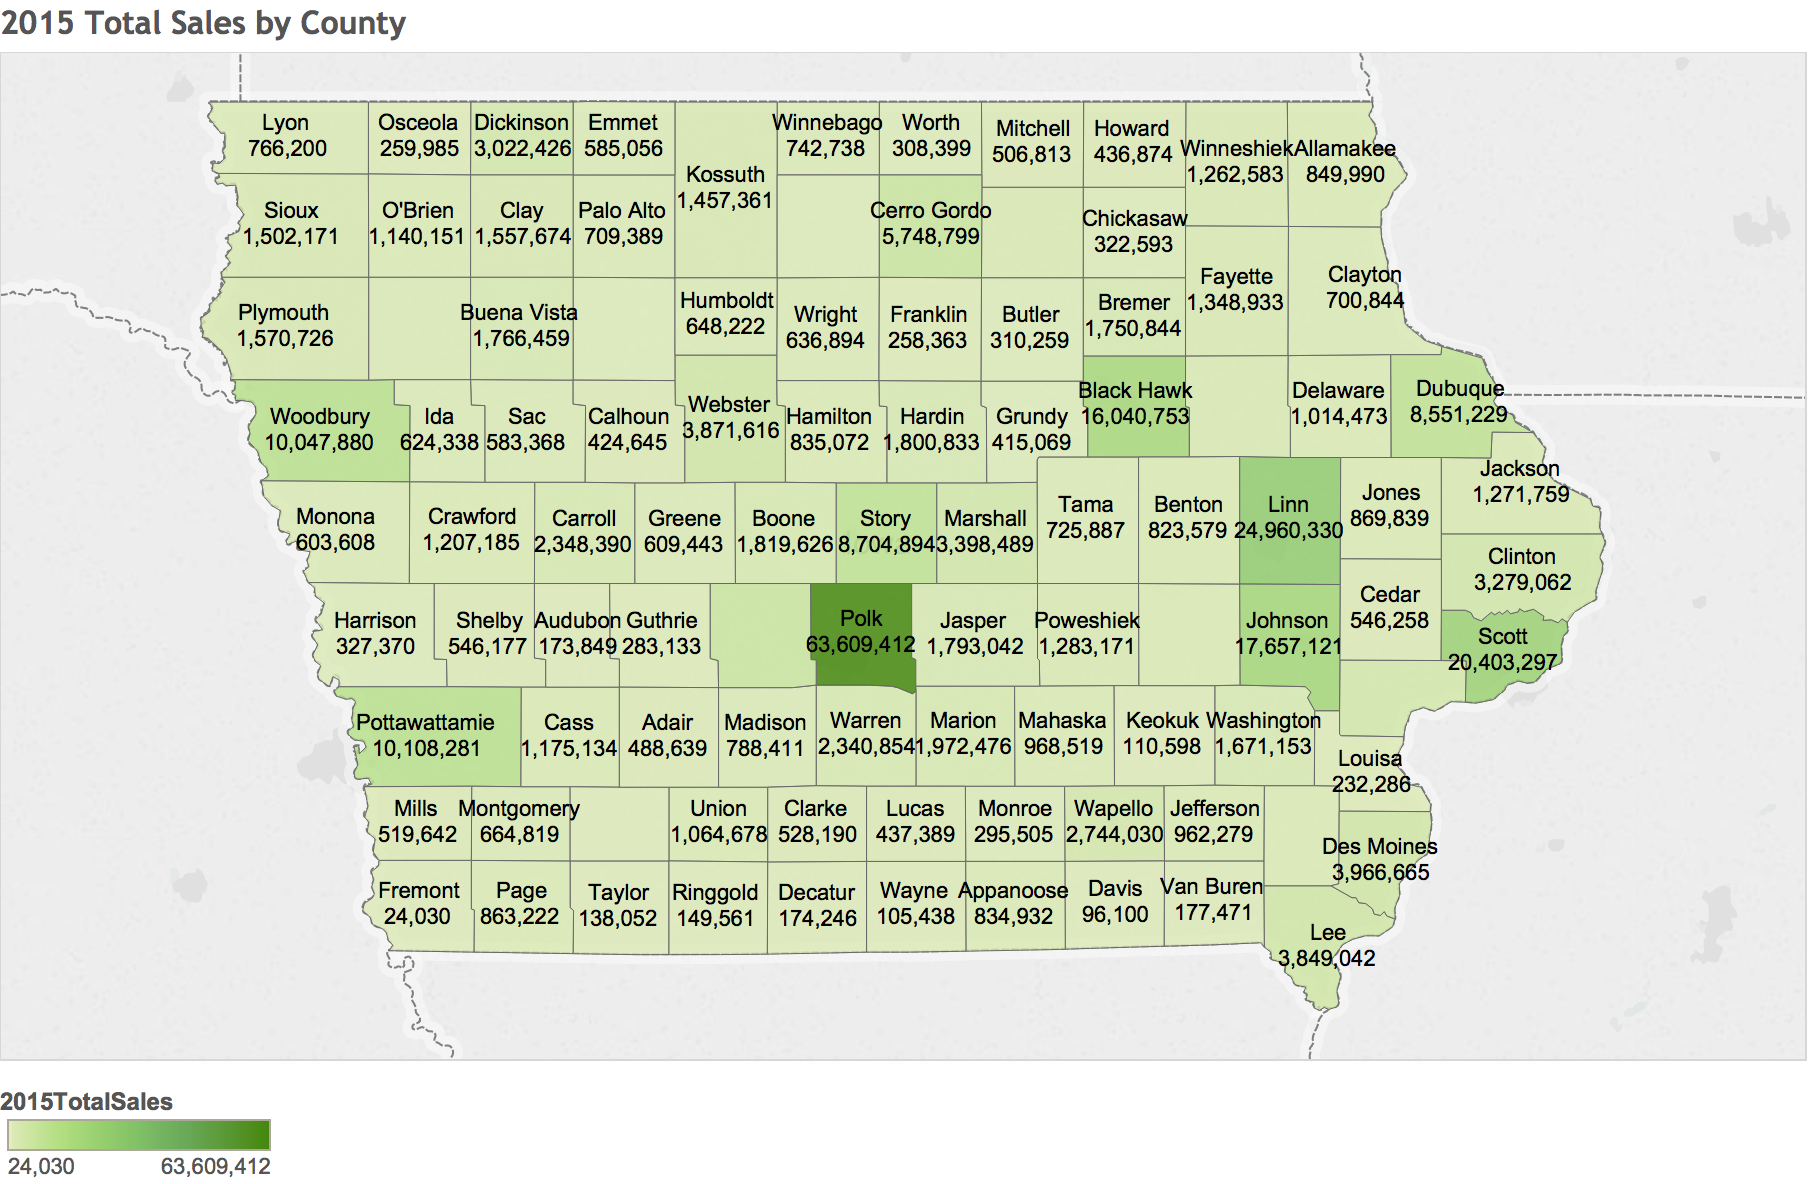

In [20]:
Image(filename='2015TotalSales.png')

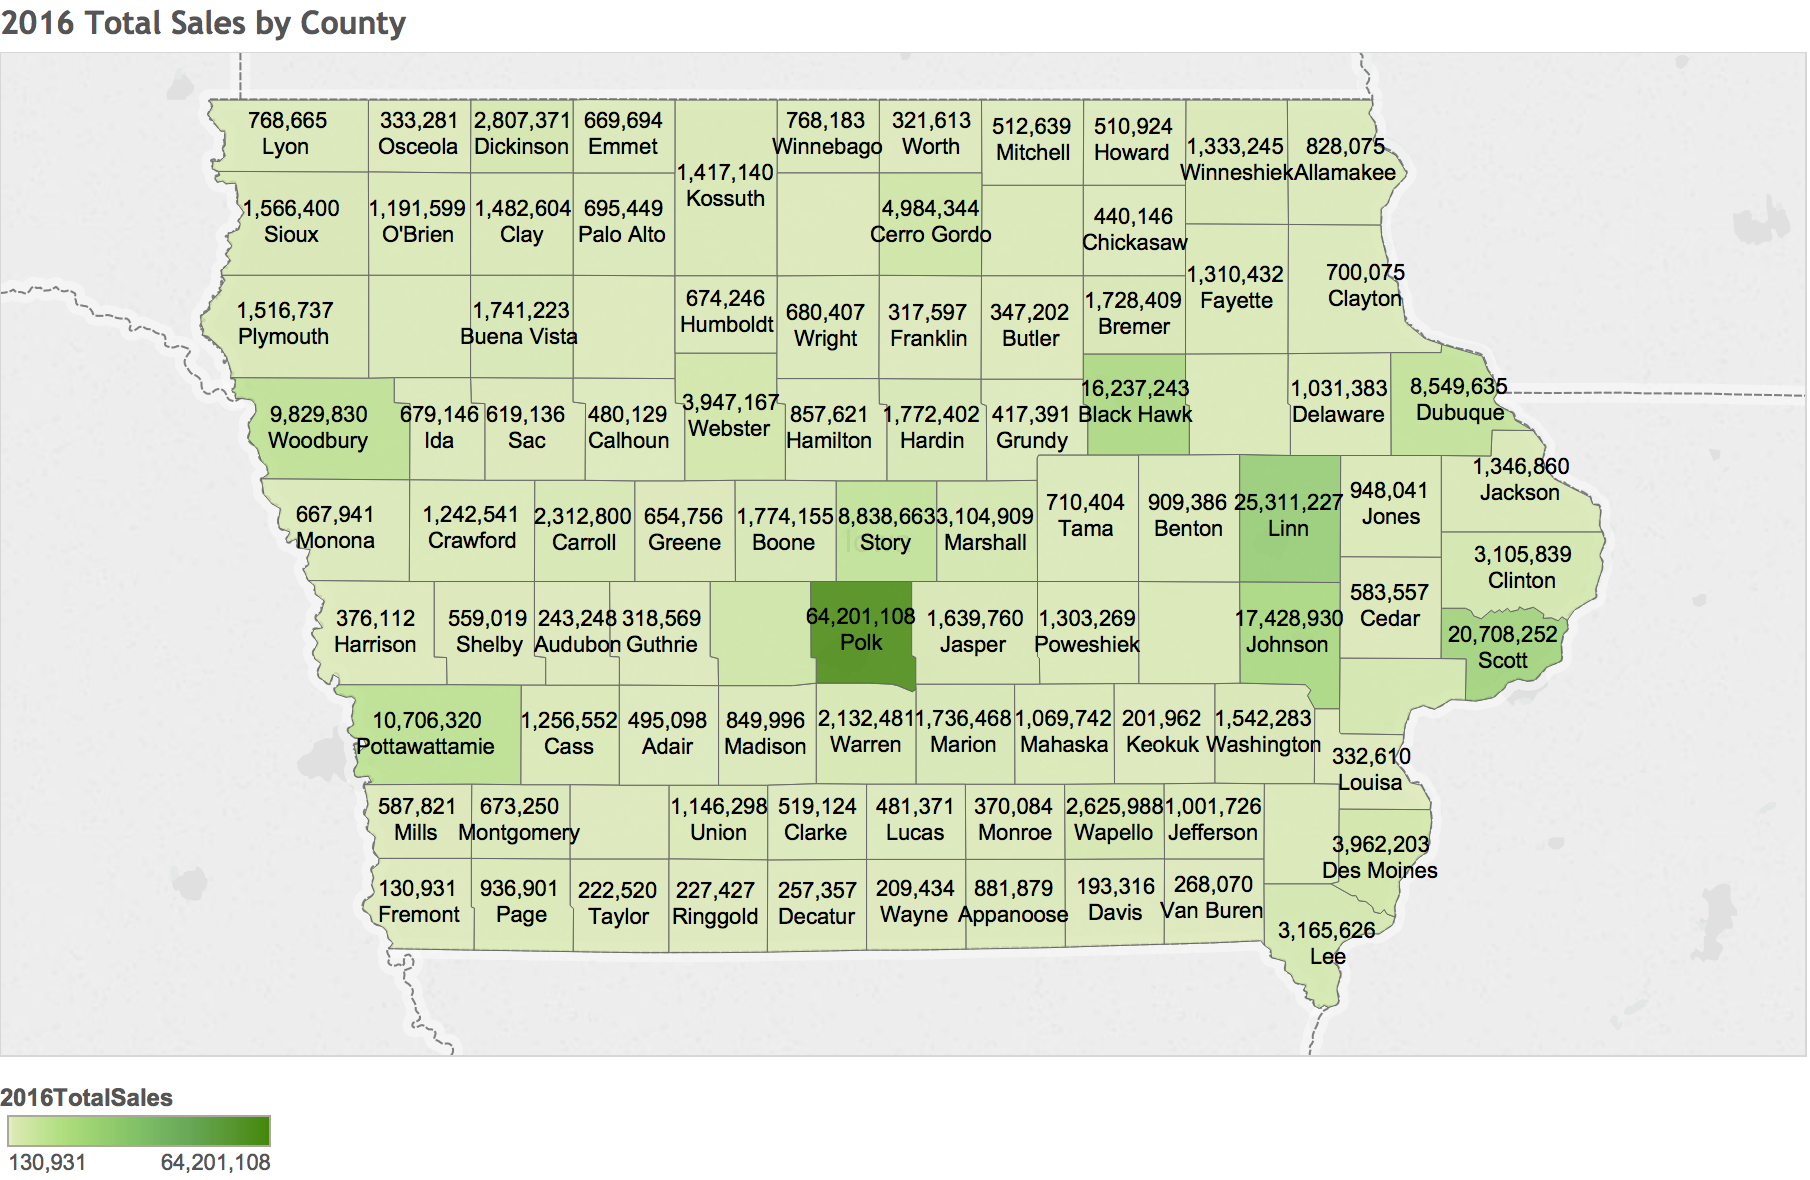

In [21]:
Image(filename='2016TotalSales.png')

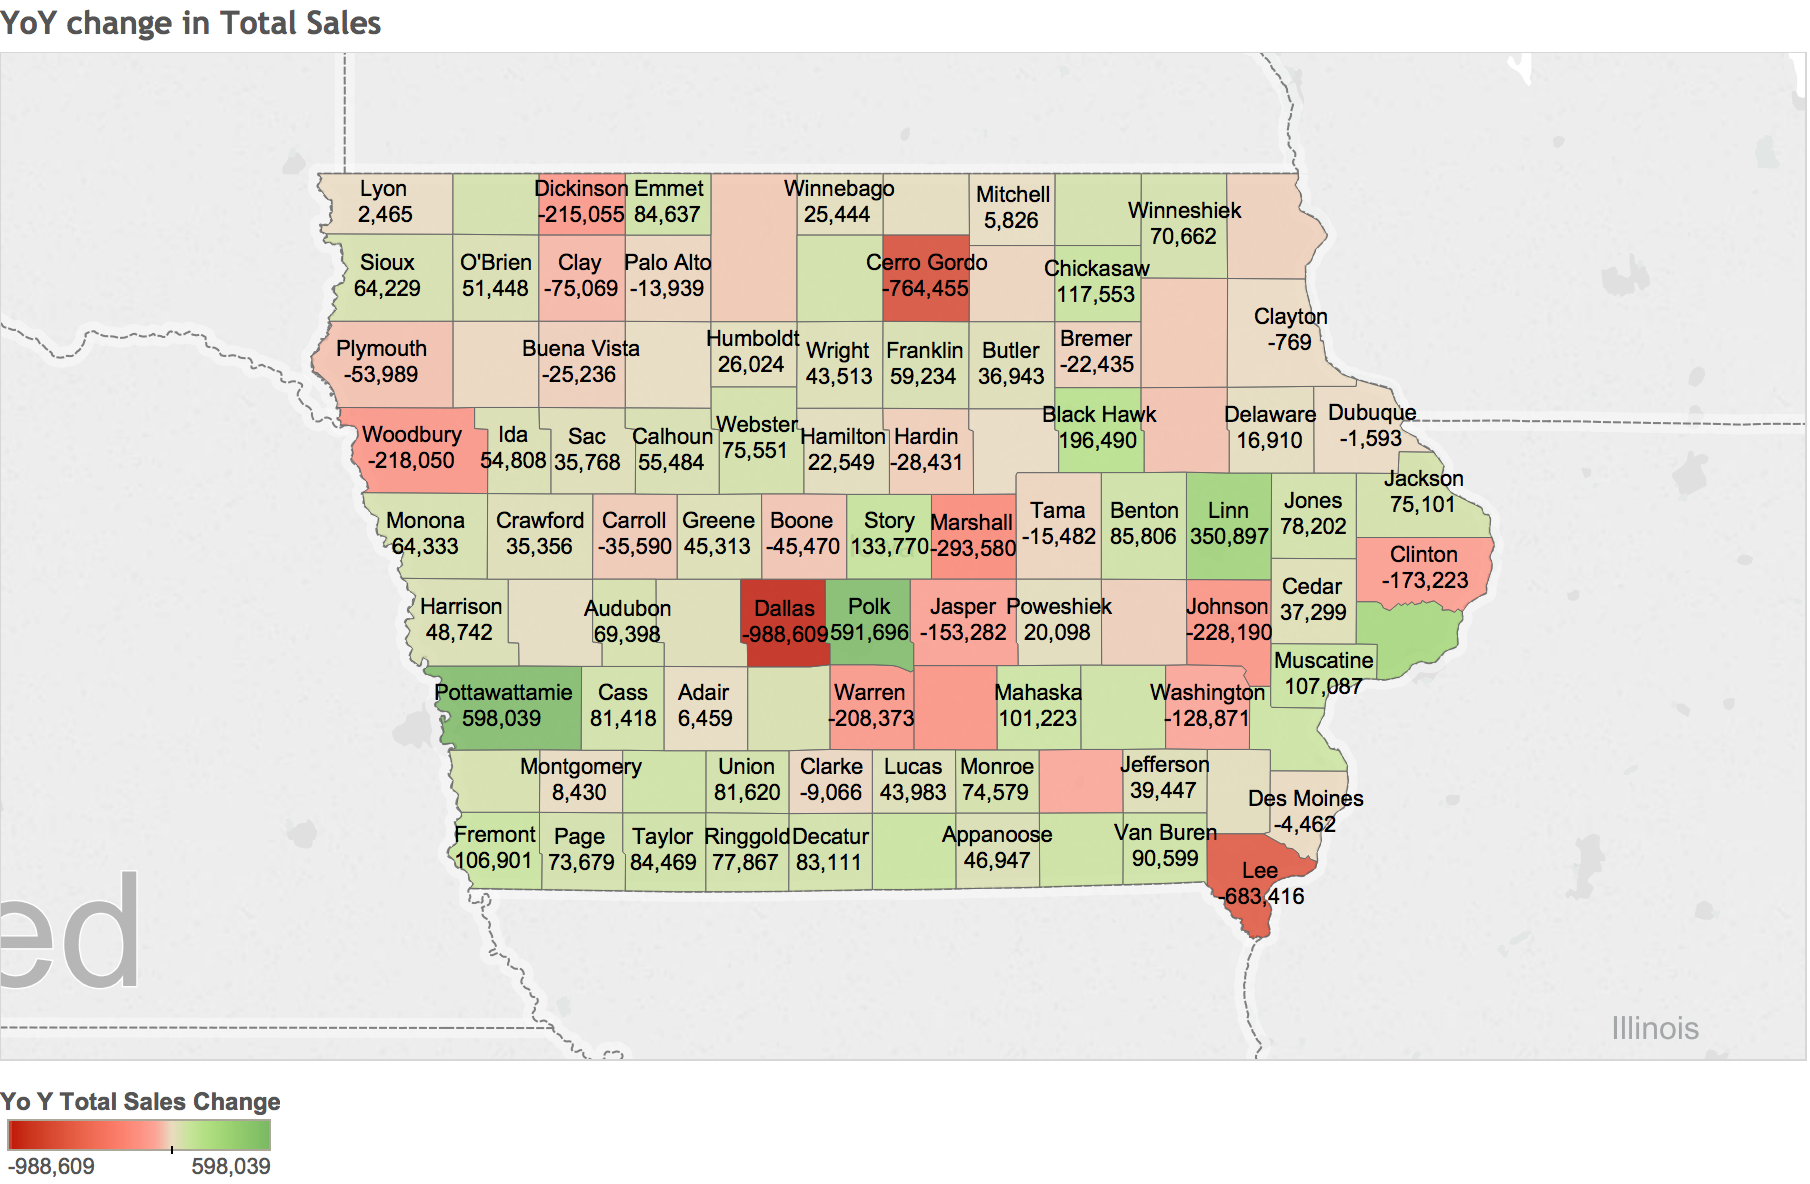

In [22]:
Image(filename='YoYSalesChange.png')

We also performed cross validation on our linear regression model to look at the results, using train/test/split and 5 fold cross validation.  The r^2 score is not affected significantly so we believe the model to be robust and not overfitted (or the data to be too uniform, which presents a whole new set of issues and problems to deal with).  

       X Shape  Y Shape
Train (66, 3) (66, 1)
Test  (33, 3) (33, 1)
Score: 0.998856493964


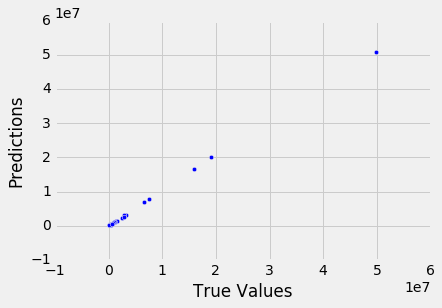

In [23]:
from sklearn.cross_validation import train_test_split

X = testq12015df[['Profit', 'VolumeSold','NumberofStores']]
y = testnotq12015df[['TotalSales']]
TestX = test2016df[['Profit', 'VolumeSold','NumberofStores']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

print "       X Shape  Y Shape"
print "Train", X_train.shape, y_train.shape
print "Test ", X_test.shape, y_test.shape

lm = linear_model.LinearRegression()
# lm = linear_model.Lasso()
# lm = linear_model.RidgeCV()

model = lm.fit(X_train, y_train)
predictions = model.predict(X_test)

## The line / model
plt.scatter(y_test, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")

print "Score:", model.score(X_test, y_test)

Cross-validated scores: [-1.72697474  0.31490901  0.51836316  0.84328142  0.99671358]
Cross-Predicted R^2: 0.997587047779


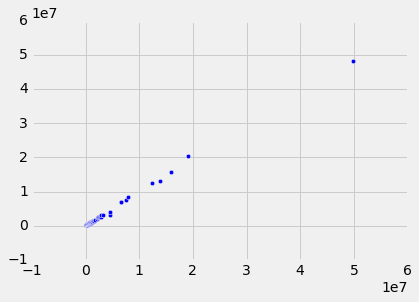

In [24]:
# Perform 5-fold cross validation
scores = cross_val_score(model, X, y, cv=5)
print "Cross-validated scores:", scores

# Make cross validated predictions
predictions = cross_val_predict(model, X, y, cv=5)
plt.scatter(y, predictions)
r2_s = r2_score(y, predictions)
print "Cross-Predicted R^2:", r2_s

One of the concerns I had while going through this was the effect that droping the null values might have on the results, so I decided to loop back and look at the null_data dataset once again.  But reexamining both the absolute number of rows removed (and percentage of the full dataset), the impact on total sales, and the distribution between the different counties (for the rows where the null value was not in the county itself), it appears to be very similar to the largest counties.  Next steps could be taking efforts to recover some of this data, either by piecing together missing values by crossmatching against county number or zipcode or city.  But for the time constraints for this project, I'm happy to leave it at this point for now.  

In [25]:
null_data['Sale (Dollars)'] = null_data['Sale (Dollars)'].apply(lambda x: dolflo(x))

In [26]:
sum(null_data['Sale (Dollars)'])/sum(df['TotalSales'])

0.0066425796996408566

In [27]:
x = len(null_data)
print x

16950


In [28]:
y = float(len(df))
print y

2692596.0


In [29]:
x/y

0.006295040176840492

In [30]:
null_data['County'].value_counts()

Polk             1536
Linn              506
Scott             505
Black Hawk        466
Johnson           345
Story             191
Woodbury          171
Pottawattamie     170
Dubuque           131
Cerro Gordo       117
Des Moines        105
Lee                93
Buena Vista        88
Marshall           87
Webster            76
Wapello            73
Muscatine          72
Clinton            69
Jasper             61
Dallas             54
Marion             49
Washington         46
Warren             46
Buchanan           42
Dickinson          40
Henry              37
Bremer             34
Carroll            32
Hardin             31
O'Brien            30
                 ... 
Montgomery          9
Cherokee            8
Madison             8
Howard              7
Clarke              7
Worth               7
Ringgold            6
Adair               5
Humboldt            5
Union               5
Guthrie             5
Greene              5
Monona              5
Osceola             4
Franklin  

Just curious what the biggest markups are on, and where they sell these ones, so creating a quick df for the pricy bottles/barrels.  

In [45]:
pricy = df1[df1['BottleMarkup']>300]

In [57]:
pricy['Item Description'].value_counts()

Macallan Sherry Cask 25YR HA                     5
Remy Martin Louis Xiii Cognac                    3
Cedar Ridge Barrel Proof Bourbon                 2
Cedar Ridge Barrel Proof Bourbon Barrel #2666    1
Cedar Ridge Barrel Proof Bourbon Barrel #2552    1
Cedar Ridge Port Cask Finish Barrel #2666        1
Cedar Ridge Port Cask Finish Barrel #2590        1
Cedar Ridge Port Cask Finish Barrel #2561        1
The Cally 40YR HA                                1
Cedar Ridge Barrel Proof Bourbon Barrel          1
Cedar Ridge Port Cask Finish Barrel #2663        1
Name: Item Description, dtype: int64

In [61]:
pricy = pricy.sort_values(by='State Bottle Retail')
pricy.head(18)

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),BottleMarkup,Profit
515842,2016-01-04,2190,DES MOINES,50314,77.0,Polk,1012200.0,SCOTCH WHISKIES,260,906278,The Cally 40YR HA,750,674.16,1011.24,2,2022.48,1.50,0.4,337.08,674.16
452410,2016-01-13,3869,CORALVILLE,52241,52.0,Johnson,1012210.0,SINGLE MALT SCOTCH,305,905502,Macallan Sherry Cask 25YR HA,750,726.81,1090.22,1,1090.22,0.75,0.2,363.41,363.41
472817,2016-01-11,2633,DES MOINES,50320,77.0,Polk,1012210.0,SINGLE MALT SCOTCH,305,905502,Macallan Sherry Cask 25YR HA,750,726.81,1090.22,1,1090.22,0.75,0.2,363.41,363.41
472818,2016-01-11,2512,IOWA CITY,52240,52.0,Johnson,1012210.0,SINGLE MALT SCOTCH,305,905502,Macallan Sherry Cask 25YR HA,750,726.81,1090.22,1,1090.22,0.75,0.2,363.41,363.41
472823,2016-01-11,4067,WELLMAN,52356,90.0,Wapello,1012210.0,SINGLE MALT SCOTCH,305,905502,Macallan Sherry Cask 25YR HA,750,726.81,1090.22,1,1090.22,0.75,0.2,363.41,363.41
472826,2016-01-11,2190,DES MOINES,50314,77.0,Polk,1012210.0,SINGLE MALT SCOTCH,305,905502,Macallan Sherry Cask 25YR HA,750,726.81,1090.22,2,2180.44,1.50,0.4,363.41,726.82
2399441,2015-02-26,4829,DES MOINES,50314,77.0,Polk,1052010.0,IMPORTED GRAPE BRANDIES,389,903056,Remy Martin Louis Xiii Cognac,750,1399.29,2098.94,1,2098.94,0.75,0.2,699.65,699.65
2105249,2015-04-20,2633,DES MOINES,50320,77.0,Polk,1052010.0,IMPORTED GRAPE BRANDIES,389,903056,Remy Martin Louis Xiii Cognac,750,1399.29,2098.94,1,2098.94,0.75,0.2,699.65,699.65
1856253,2015-06-01,2633,DES MOINES,50320,77.0,Polk,1052010.0,IMPORTED GRAPE BRANDIES,389,903056,Remy Martin Louis Xiii Cognac,750,1449.26,2173.89,2,4347.78,1.50,0.4,724.63,1449.26
959034,2015-10-27,2552,CEDAR RAPIDS,52404,57.0,Linn,1011250.0,SINGLE BARREL BOURBON WHISKIES,125,987089,Cedar Ridge Barrel Proof Bourbon Barrel #2552,750,5800.00,8700.00,1,8700.00,0.75,0.2,2900.00,2900.00


In [49]:
pricy = pricy[pricy['Bottle Volume (ml)']<170000]
pricy.tail()

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),BottleMarkup,Profit
959034,2015-10-27,2552,CEDAR RAPIDS,52404,57.0,Linn,1011250.0,SINGLE BARREL BOURBON WHISKIES,125,987089,Cedar Ridge Barrel Proof Bourbon Barrel #2552,750,5800.00,8700.00,1,8700.00,0.75,0.2,2900.00,2900.00
971130,2015-10-26,2590,CEDAR RAPIDS,52402,57.0,Linn,1011300.0,TENNESSEE WHISKIES,125,987086,Cedar Ridge Port Cask Finish Barrel #2590,750,6000.00,9000.00,1,9000.00,0.75,0.2,3000.00,3000.00
1856253,2015-06-01,2633,DES MOINES,50320,77.0,Polk,1052010.0,IMPORTED GRAPE BRANDIES,389,903056,Remy Martin Louis Xiii Cognac,750,1449.26,2173.89,2,4347.78,1.50,0.4,724.63,1449.26
2105249,2015-04-20,2633,DES MOINES,50320,77.0,Polk,1052010.0,IMPORTED GRAPE BRANDIES,389,903056,Remy Martin Louis Xiii Cognac,750,1399.29,2098.94,1,2098.94,0.75,0.2,699.65,699.65
2399441,2015-02-26,4829,DES MOINES,50314,77.0,Polk,1052010.0,IMPORTED GRAPE BRANDIES,389,903056,Remy Martin Louis Xiii Cognac,750,1399.29,2098.94,1,2098.94,0.75,0.2,699.65,699.65


In [47]:
pricy['Item Description'].value_counts()

Macallan Sherry Cask 25YR HA                     5
Remy Martin Louis Xiii Cognac                    3
Cedar Ridge Barrel Proof Bourbon                 2
Cedar Ridge Barrel Proof Bourbon Barrel #2666    1
Cedar Ridge Barrel Proof Bourbon Barrel #2552    1
Cedar Ridge Port Cask Finish Barrel #2666        1
Cedar Ridge Port Cask Finish Barrel #2590        1
Cedar Ridge Port Cask Finish Barrel #2561        1
The Cally 40YR HA                                1
Cedar Ridge Barrel Proof Bourbon Barrel          1
Cedar Ridge Port Cask Finish Barrel #2663        1
Name: Item Description, dtype: int64

In [33]:
# Curious where these things are being sold 
pricy['City'].value_counts()

DES MOINES      7
CEDAR RAPIDS    5
ANKENY          2
CORALVILLE      1
IOWA CITY       1
URBANDALE       1
WELLMAN         1
Name: City, dtype: int64

# Conclusions

After going through some of the data visualizations and the models, I believe an argument can be made for opening a new store in Polk, Scott, or Lin county.  We took a look at the data visualizations for last year, along with the model's data visualizations for the rest of 2016 and believe that those counties are attractive due to the high sales and profit per store numbers and forecasted sales for the rest of 2016.  Average profit margin per bottle should range from 4.10 to 4.73 and the number of bottles sold can also be prescribed based on which county is chosen.  Polk county continues to be a strong area for liquor store sales - further analysis can be made to specify cities within Polk county.  We could also, once finishing this exercise, come up with an analysis on the best selling types of alcohol, along with seasonality analysis.  